In [ ]:
# Clone the repository if running in Colab and install all the dependencies
if 'google.colab' in str(get_ipython()):
    import sys
    import os
    try:
      !git clone https://github.com/lasseufpa/ml4comm-icc21.git
    except:
      print("ml4comm-icc21 is already in the contents")
    !pip install -r /content/ml4comm-icc21/requirements.txt  &>/dev/null
    !pip install imbalanced &>/dev/null
    sys.path.append(os.path.abspath('/content/ml4comm-icc21'))

In [5]:
import sys
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy as np

from commpy.channels import SISOFlatChannel

sys.path.append(os.path.abspath('ml4comm'))
from ml4comm.qam_awgn import generate_symbols
from ml4comm.qam_crazy import crazy_channel_propagate
from ml4comm.qam_analyzer import plot_decision_boundary, ser, plot_confusion_matrix

np.random.seed(52) # Important

In [6]:
from imblearn.under_sampling import RandomUnderSampler

class Dataset:
    def __init__(self, channel_type='awgn'):
        self.M            = 16      # QAM modulation
        self.num_symbols  = 6000    # Number of transmitted symbols
        self.SNR_dB       = 15      # Signal to noise ratio in dB     
        self.code_rate    = 1       # Rate of the used code
        self.Es           = 1       # Average symbol energy
        
        # Generate the QAM symbols
        symbs, indices = generate_symbols(self.num_symbols, self.M)
        
        if channel_type == 'awgn':
          channel = SISOFlatChannel(None, (1 + 0j, 0j))
          channel.set_SNR_dB(self.SNR_dB, float(self.code_rate), self.Es)
          channel_output = channel.propagate(symbs)
        elif channel_type == 'crazy':
          channel_output = crazy_channel_propagate(symbs, self.SNR_dB)
        else:
          raise Exception("Channel type must be 'awgn' or 'crazy'")
          
      
        # Train
        self.train_size = int(0.5*len(indices))
        self.y_train = indices[:self.train_size]
        self.X_train = np.stack([np.real(channel_output[:self.train_size]),
                            np.imag(channel_output[:self.train_size])], axis=1)
      
        # Test
        self.y_test = indices[self.train_size:]
        self.X_test = np.stack([np.real(channel_output[self.train_size:]),
          np.imag(channel_output[self.train_size:])], axis=1)
  
    def get_train_dataset(self, n_samples=3000):
        if n_samples > 3000:
            raise Exception("Max size is 3000")
        # if n_samples // self.M < 5:
        #   raise Exception("Less than 5 samples for each class, set n_samples = self.M * 5 at least")
        
        rus = RandomUnderSampler(sampling_strategy = {c:n_samples//self.M for c in range(self.M)}, random_state=52)
        try:
            return rus.fit_resample(self.X_train, self.y_train)
        except ValueError:
            return (self.X_train[:n_samples], self.y_train[:n_samples])
        
    def get_test_dataset(self):
        return (self.X_test, self.y_test)

In [7]:
from sklearn.naive_bayes import GaussianNB

def get_classifier(X_train, y_train):
    clf = GaussianNB(var_smoothing=0.02)
    return clf.fit(X_train, y_train)

In [8]:
ds = Dataset(channel_type='crazy')
X_train, y_train = ds.get_train_dataset(n_samples=64)
X_test, y_test = ds.get_test_dataset()
clf = get_classifier(X_train, y_train)

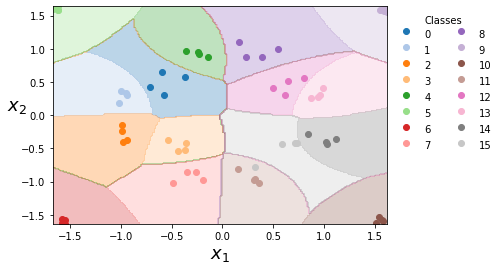

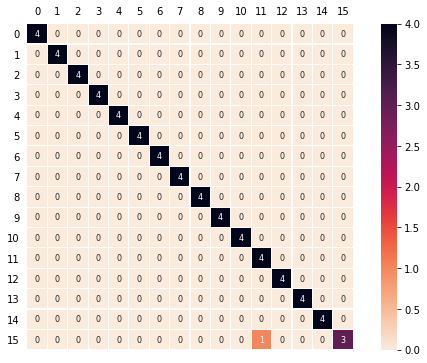

[Train set] Gaussian Naive Bayes:
 SER:	 1.56%


In [11]:
plot_decision_boundary(clf, X_train, y_train, legend=True)
plot_confusion_matrix(clf, X_train, y_train, ds.M)
clf_train_ser = ser(clf, X_train, y_train)
print(f'[Train set] Gaussian Naive Bayes:\n SER:\t {clf_train_ser:.2%}')

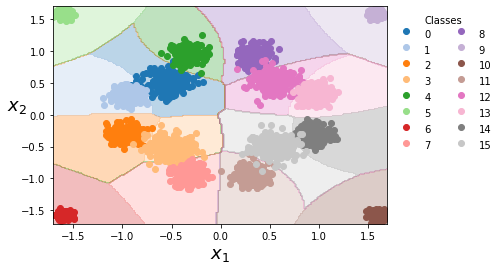

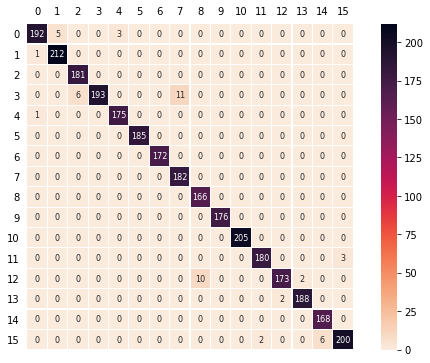

[Train set] Gaussian Naive Bayes:
 SER:	 1.56%


In [10]:
plot_decision_boundary(clf, X_test, y_test, legend=True)
plot_confusion_matrix(clf, X_test, y_test, ds.M)
clf_test_ser = ser(clf, X_test, y_test)
print(f'[Test set] Gaussian Naive Bayes:\n SER:\t {clf_test_ser:.2%}')